<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/05_TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import glob
import numpy as np

In [ ]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle

**Read the pickle files**





In [ ]:
pathData = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

In [ ]:
with open(pathData + 'readyForTraining.pk', 'rb') as f:
  df = pickle.load(f)
df.head()

,ITEM_ID,SLS_CNTR_ID,DATE1,QTY,isSalaryweek,isWeekend,isNationalday,isRamadan,isRamadanEnd,isEid,Monthday,Holiday,AcademicCalendarSemester
0,0020,13,2022-01-12,1.0,0,0,0,0,0,0,12,0,0
1,0035,13,2022-01-12,3.0,0,0,0,0,0,0,12,0,0
2,0035,28,2022-01-12,2.0,0,0,0,0,0,0,12,0,0
3,011810029,18,2022-01-12,1.0,0,0,0,0,0,0,12,0,0
4,100000103,48,2022-01-12,1.0,0,0,0,0,0,0,12,0,0


In [ ]:
print("number of records:", len(df))

number of records: 7288431


In [ ]:
df.set_index("DATE1", inplace = True)

**Train / Test Split**

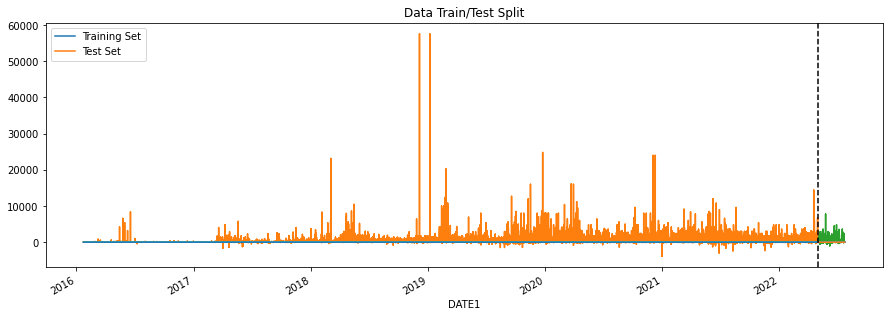

In [ ]:
train = df.loc[df.index.get_level_values('DATE1') < '2022-05-01'] # df.index.get_level_values('DATE1').dayofweek == 0
test = df.loc[df.index.get_level_values('DATE1') >= '2022-05-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2022-05-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Create the Model**

In [ ]:
#DataFrame.dtypes for data must be int, float or bool, so we are removing 'ITEM_ID' and 'DATE1'
FEATURES = ['SLS_CNTR_ID', 'isSalaryweek', 'AcademicCalendarSemester', 'isWeekend', 'isEid']
TARGET = 'QTY'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror', # instead of 'reg:linear' that is deprecated 
                       max_depth=3,
                       learning_rate=0.01)

In [ ]:
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:30:23] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:77.6084	validation_1-rmse:52.3432
[100]	validation_0-rmse:76.7227	validation_1-rmse:50.8805
[200]	validation_0-rmse:76.3536	validation_1-rmse:50.2728
[300]	validation_0-rmse:76.1655	validation_1-rmse:50.0278
[400]	validation_0-rmse:76.0895	validation_1-rmse:49.8927


Save the model

In [ ]:
with open(pathData + 'model.pk', 'wb') as f:
  pickle.dump(reg, f)

**Feature Importance**

In [ ]:
#from xgboost import XGBRegressor

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

**Forecast on Test**

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['salesQty']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

**Score (RMSE)**

In [ ]:
score = np.sqrt(mean_squared_error(test['salesQty'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

**Calculate Error**


*   Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

**Save weights**


*   Save the model and its weights to be used for predection with other set of data

